In [8]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import scipy.stats as stats

# Comment here to add in for either mac or linux computer
# sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # For mac laptop
sys.path.extend(['/data/GitHub/NeuroPy'])  # for linux

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch, ProcessData
from neuropy.io.spykingcircusio import SpykingCircusIO
from neuropy.utils.signal_process import filter_sig, FourierSg
from neuropy.analyses.oscillations import Ripple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# diruse = "/data3/Psilocybin/Recording_Rats/Rey/2022_06_02_psilocybin" # line noise issues!
# diruse = "/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin"
diruse = "/data3/Psilocybin/Recording_Rats/Rose/2022_08_11_saline2"
sess = ProcessData(diruse)
print(sess.recinfo)

filename: /data3/Psilocybin/Recording_Rats/Rose/2022_08_11_saline2/Rose_saline2_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [61]:
signal = sess.eegfile.get_signal()

In [63]:
from neuropy.analyses.artifact import detect_artifact_epochs

art_epochs_source_file = sess.filePrefix.with_suffix('.artifact.npy')

if art_epochs_source_file.is_file():
    art_epochs = Epoch(epochs=None, file=art_epochs_source_file)
    print('pre-existing epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=2, merge=6)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_source_file)
art_epochs

pre-existing epochs file loaded


2 epochs
Snippet: 
        start       stop label
0   677.5472   678.7576      
1  2944.3768  2948.3608      

#### Now check artifact detection in two ways:
1) Plot using the code below to see if you detected all the disconnects artifacts, and
2) load the .evt.art file into neuroscope and make sure you aren't missing anything

Sanity check

<Axes: >

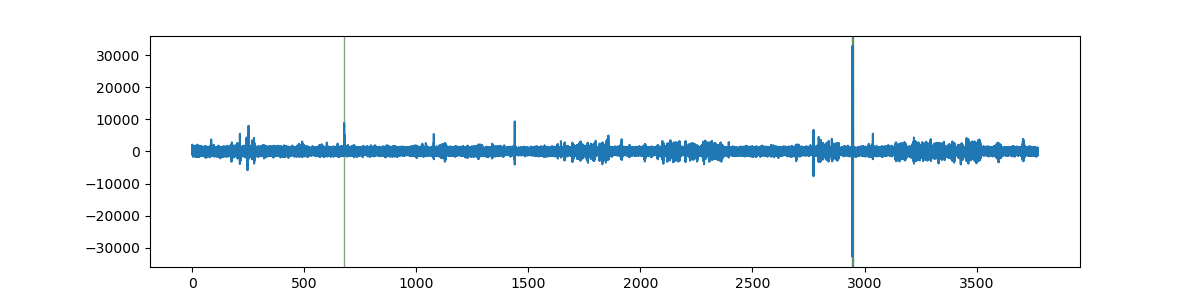

In [64]:
%matplotlib widget
from neuropy.plotting.signals import plot_signal_w_epochs
_, ax = plt.subplots(figsize=(12, 3))
plot_signal_w_epochs(signal, channel=4, epochs=art_epochs, ax=ax)

Run the code below if you need to adjust manually

In [ ]:
from copy import deepcopy

## Manually fix missing noise epoch in middle!
# art_list = [[1316, 1410.5]]  # Fill in list of times of any missed artifacts here
# art_epochs_fix = deepcopy(art_epochs)
# for (start, stop) in art_list:
#     art_epochs_fix = art_epochs_fix.add_epoch_manually(start, stop)

# sess.recinfo.write_epochs(epochs=art_epochs_fix, ext='art')
# art_epochs_fix.save(art_epochs_source_file)
# art_epochs_fix.to_dataframe()
# art_epochs = art_epochs_fix

In [65]:
df = art_epochs.to_dataframe()
print(f'Total artifact duration = {df.duration.sum()/60:0.000g} minutes')
df.sort_values(by=['duration']).tail(5)

Total artifact duration = 0.09 minutes


,start,stop,label,duration
0,677.5472,678.7576,,1.2104
1,2944.3768,2948.3608,,3.9840


In [66]:
from neuropy.analyses.oscillations import detect_ripple_epochs
rpl_channel = 26 # Rey 27 # Finn 21 # Rey Fill in here
# session_directory = # Fill in here
window = 300 # seconds
overlap = 150 # seconds
# sess = ProcessData(session_directory)
signal = sess.eegfile.get_signal()

try:
    sess.ripple = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".ripple.npy"))
except FileNotFoundError:
    sess.ripple = detect_ripple_epochs(signal.time_slice(channel_id=rpl_channel), 
                                       ignore_epochs=art_epochs)  # fill in appropriate inputs here
    sess.recinfo.write_epochs(sess.ripple, ext="swr") # Save to neuroscope
    sess.ripple.save(sess.filePrefix.with_suffix(".ripple.npy"))

Selected channels for ripples: [26]
2206 epochs remaining with durations within (0.05,0.45)
/data3/Psilocybin/Recording_Rats/Rose/2022_08_11_saline2/Rose_saline2_denoised.ripple.npy saved


### Make sure to visualize all ripples in Neuroscope before proceeding to make sure ripple detection looks ok

In [67]:
rpl_df = Ripple.get_peak_ripple_freq(sess.eegfile, sess.ripple).to_dataframe()

/tmp/ipykernel_516775/1212455606.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()  # Create Figure and gather ripple spectrum data


(125.0, 250.0)

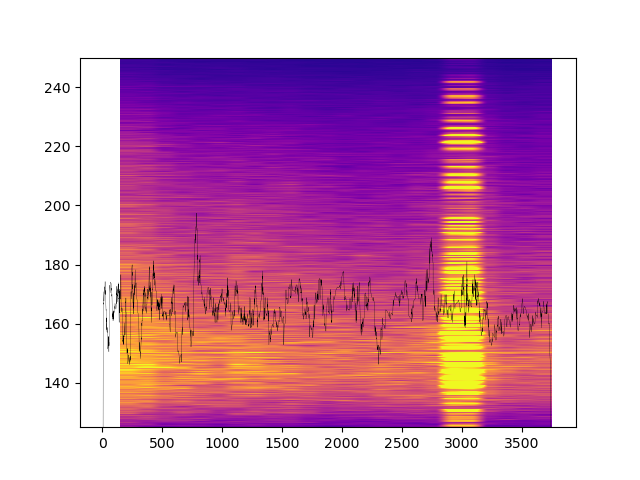

In [70]:
%matplotlib widget
signal = sess.eegfile.get_signal(rpl_channel)
signal = filter_sig.bandpass(signal, lf=125, hf=250)
spect = FourierSg(signal, window=window, overlap=overlap).freq_slice(125, 250)  # Run Fourier on all ripples
# Add in code here to get peak ripple frequency and add to rpl_df - make sure you save peak frequency to 'peak_frequency_bp' column in rpl_df dataframe

# Dump data into dictionary for easy reference later
ripple_spect = dict(
            sxx=spect,
            time=rpl_df.start.values,
            freq=rpl_df.peak_frequency_bp,
        )
_, ax = plt.subplots()  # Create Figure and gather ripple spectrum data
sxx = ripple_spect["sxx"]

# Check if any artifacts are present
spect_art_bool = spect.traces.mean(axis=0) > spect.traces.mean(axis=0).std() * 10
if np.any(spect_art_bool):
    spect.traces[:, spect_art_bool] = np.nan
# ripple_spect["sxx"] = 
time = ripple_spect["time"]
im = ax.imshow(
        stats.zscore(sxx.traces, axis=None, nan_policy='omit'),
        aspect="auto",
        # vmin=-0.,
        vmax=1,
        cmap="plasma",
        # norm=mcolors.LogNorm(0.0000001,0.07),
        origin="lower",
        extent=[sxx.time[0], sxx.time[-1], sxx.freqs[0], sxx.freqs[-1]],
    )
mov_window = (1 / 20) * np.ones(20)  # Smooth by averaging frequency of every 20 ripples together before plotting peak frequency line
ax.plot(ripple_spect["time"], np.convolve(ripple_spect["freq"], mov_window, mode="same"), 
        "k", lw=0.2)
ax.set_ylim(125, 250)
 

### Add in injection time - for later

In [ ]:
inject_time = pd.Timestamp(year=2022, month=2, day=15, hour=12, minute=50, tz='America/Detroit')
inject_time

In [ ]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

In [ ]:
start_time = sync_df.Datetime[0]
tinject_sec = (inject_time - start_time).total_seconds()
rec_times_sec = (sync_df.Datetime - start_time).dt.total_seconds()
rec_times_sec
tinject_sync_sec = np.interp(tinject_sec, rec_times_sec, sync_df.eeg_time)

starts = [0, tinject_sync_sec]
stops = [tinject_sync_sec - 1/sess.eegfile.sampling_rate, sess.eegfile.duration]
inject_epochs = Epoch(pd.DataFrame({"start": starts, "stop": stops, "label": ["PRE", "POST"]}))
sess.recinfo.write_epochs(inject_epochs, 'inj')
sess.inject_epochs = inject_epochs
sess.inject_epochs.save(sess.filePrefix.with_suffix('.injection.npy'))
inject_epochs

Above is ok - disconnect for last bit of recording accounts for no spikes in the last 40ish seconds

In [ ]:
pyr_bool = np.bitwise_and(sess.phy.cluster_info['depth'] >= 100, sess.phy.cluster_info['depth'] <= 450)
cort_bool = np.bitwise_not(pyr_bool)

In [ ]:
np.concatenate((sess.phy.spiketrains[0:5], sess.phy.spiketrains[0:3])).shape

In [ ]:
from neuropy.core.neurons import Neurons
sess.pyr_neurons = Neurons(sess.phy.spiketrains[pyr_bool], t_stop=sess.eegfile.duration, sampling_rate=1,
                      neuron_type=sess.phy.cluster_info['q'])
npyr = pyr_bool.sum()
print('First ' + str(npyr) + ' neurons are pyramidal')
trains_all = np.concatenate((sess.phy.spiketrains[pyr_bool], sess.phy.spiketrains[cort_bool]))
sess.all_neurons = Neurons(trains_all, t_stop=sess.eegfile.duration, sampling_rate=1,
                      neuron_type=sess.phy.cluster_info['q'])

In [ ]:
sess.phy.cluster_info

Calculate MUA

In [ ]:
sess.mua = sess.pyr_neurons.get_mua(bin_size=0.05)

Import curated ripple data

In [ ]:
from neuropy.core.epoch import Epoch
sess.ripple = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple_curated.npy'))

In [ ]:
a = sess.ripple.to_dataframe()